In [3]:
from utilis.utilis import *
from utilis.mdn_utilis import *
from utilis.gen_model_utilis import *
from get_datasets import *

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import numpy as np
from scipy import spatial
from scipy.stats import norm, uniform
from tqdm import tqdm

# Mixture of linear functions dataset

### Get dataset

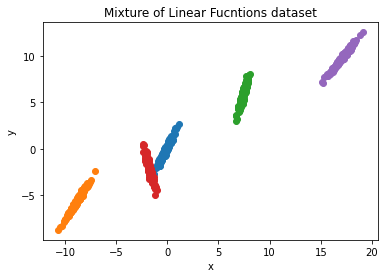

In [6]:
num_components = 5
data = get_dataset__many_linear_functions(N = 1000, num_components=num_components)
x, y, cluster_assignment, y_shift = data['train']
plot_dataset(x, y, cluster_assignment, title="Mixture of Linear Fucntions dataset")

### Train a model

In [7]:
model = simple_model(input_shape=1+num_components)

In [8]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [9]:
epochs = 50
model_input = np.concatenate([y.reshape(-1, 1), clusters_one_hot], axis=-1)
print(model_input.shape)
model.fit(model_input, x, epochs=epochs)

(900, 6)
Epoch 1/50
29/29 [==============================] - 0s 1ms/step - loss: 44.6190
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 3.8568
Epoch 3/50
29/29 [==============================] - 0s 1ms/step - loss: 1.7886
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 1.0591
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 0.7439
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6243
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 0.5423
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5412
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4382
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4018
Epoch 11/50
29/29 [==============================] - 0s 1ms/step - loss: 0.3860
Epoch 12/50
29/29 [==============================] - 0s 1ms/step - loss: 0.3992
Epoch 13/50
29/29 [====================

### Confirm model of p(x|y,c) is working

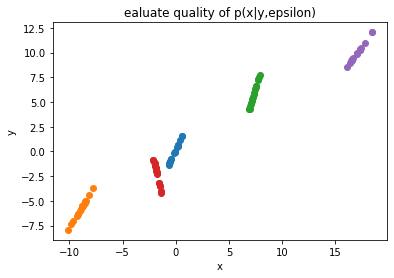

In [10]:
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1
model_input = np.concatenate([y_test.reshape(-1, 1), clusters_one_hot_test], axis=-1)

x_pred = model.predict(model_input)
plot_dataset(x_pred, y_test, cluster_assignment_test, title="ealuate quality of p(x|y,epsilon)")

### Specify some parameters for model

In [12]:
# specify number of points N_y, N_x for which to evaluate probability 
N_y = 4000
N_x = 4000

x_range = [x_test.min() -3, x_test.max() +3]
y_range = [y_test.min() - 3, y_test.max() +3]

### Get and plot conditional probability p(y|x)

In [15]:
x_sample = [-2]
arguments = [x_sample, model, num_components, y_range, N_y, y_shifts]
p_y_given_x = get_probability(arguments, dataset_type="sin_or_lin_dataset")

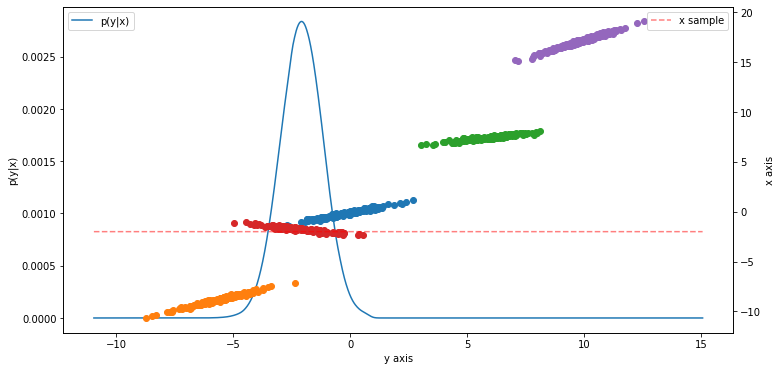

In [16]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get and plot joint probability p(x,y)

In [19]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
arguments = [x_queries, model, num_components, y_range, N_y, y_shifts]
heat_map = get_probability(arguments, dataset_type="sin_or_lin_dataset")

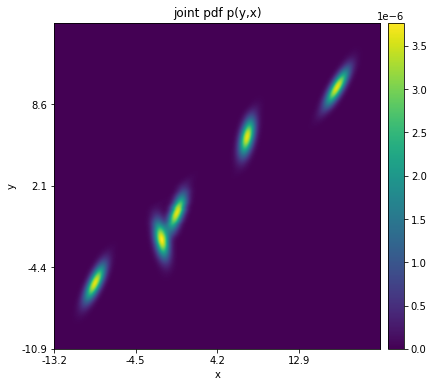

In [20]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)

# Mixture of inverted sinusoids

## 1. single sinusoid

\begin{align}
p(x,y,\epsilon) = p(x|y,\epsilon)p(y)p(\epsilon)
\end{align}

* $p(y)$ = Uniform(-1,1)
* $p(\epsilon)$ = N(0,0.1)
* $p(x|y,\epsilon)$ = approximate with neural network

### A. Get dataset

In [27]:
num_components = 1

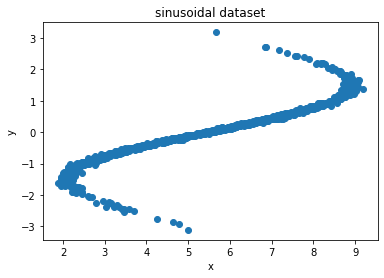

In [21]:
data = get_dataset__inverted_sinusoid(N=1000, num_sinusoids=num_components)
x, y, cluster_assignment, y_shifts = data['train']
plot_dataset(x, y, cluster_assignment, title="sinusoidal dataset")

### B. Train $p(x|t,\epsilon)$

In [22]:
model = simple_model(input_shape=1)

In [23]:
epochs = 100
model.fit(y, x, epochs=epochs, verbose=0)

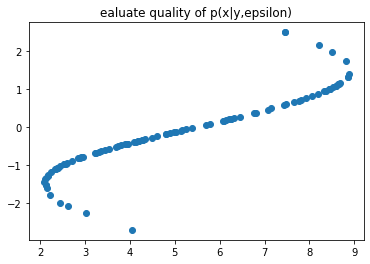

In [24]:
x_test, y_test, cluster_assignment_test, epsilon_test = data['test']

# model_input = np.stack([y_test, epsilon_test]).T
x_pred = model.predict(y_test)
plt.scatter(x_pred, y_test)
plt.title('ealuate quality of p(x|y,epsilon)')
plt.show()

### C. get $p(y|x) = \frac{\frac{1}{D}\sum^{D}_{i=1}p(x|y,\epsilon_i)p(y)p(\epsilon_i)}{\frac{1}{D}\sum^{D}_{i=1}\sum^{M}_{j=1}p(x|y_j,\epsilon_i)p(y_j)p(\epsilon_i)}$   where: $y_j \sim Uniform(-1,1)$ and $\epsilon_i \sim N(0,0.1)$

let's assume that p(x|y,epsilon) is a gaussian N(x;f(y), sigma) and that we are predicting just means assuming constant noise. So in effect we don't need to sum over epsilon because noise is implicit.

In [25]:
# specify number of points N_y, N_x for which to evaluate probability 
N_y = 500
N_x = 500

x_range = [x_test.min() -3, x_test.max() +3]
y_range = [y_test.min() - 3, y_test.max() +3]

In [28]:
x_sample = [3]
arguments = [x_sample, model, num_components, y_range, N_y, y_shifts]
p_y_given_x = get_probability(arguments, dataset_type="sin_or_lin_dataset")

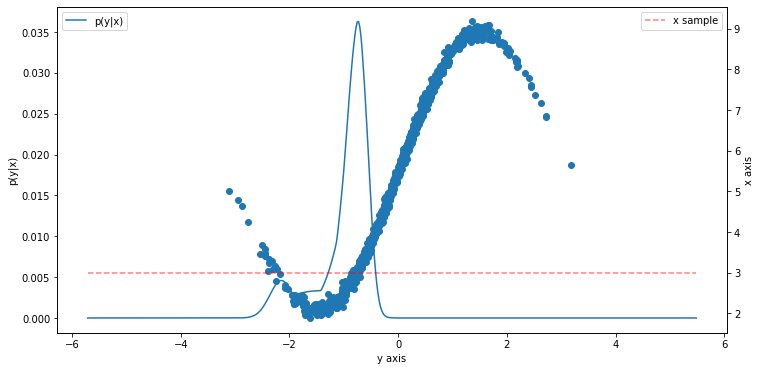

In [36]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### D. get a heatmap

In [37]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
arguments = [x_queries, model, num_components, y_range, N_y, y_shifts]
heat_map = get_probability(arguments, dataset_type="sin_or_lin_dataset")

/home/mlmi-2020/jz522/localisation_from_image_project/debugging/set_of_explenation_toy_example/utilis/gen_model_utilis.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  x_labels = np.round(np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / num_x_ticks),1)
/home/mlmi-2020/jz522/localisation_from_image_project/debugging/set_of_explenation_toy_example/utilis/gen_model_utilis.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  y_labels = np.round(np.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / num_y_ticks),1)


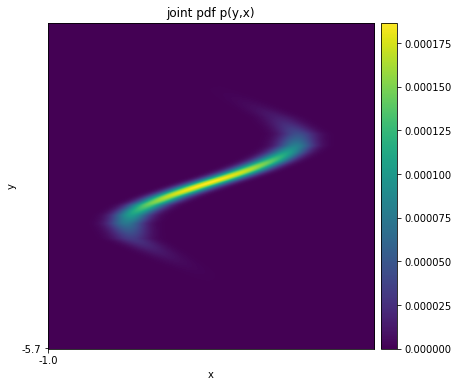

In [38]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)

## 2. mixture of sinusoids

\begin{align}
p(x,y, c, \epsilon) = p(x|y,c,\epsilon)p(y|c)p(c)p(\epsilon)
\end{align}

* $p(y|c_i) = N(g(c_i), 1)$
* $p(c)$ = Categorical_Uniform(5 categories)
* $p(\epsilon)$ = N(0,0.1)
* $p(x|y,c,\epsilon)$ = approximate with neural network

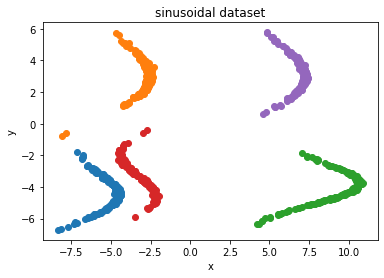

In [46]:
num_components = 5
data = get_dataset__inverted_sinusoid(N=1000, num_sinusoids=num_components)
x, y, cluster_assignment, y_shifts = data['train']
plot_dataset(x, y, cluster_assignment, title="sinusoidal dataset")

### A. Train $p(x|y,c,\epsilon)$

In [47]:
model = simple_model(input_shape=(1+num_components))

In [48]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [49]:
epochs = 200
model_input = np.concatenate([y.reshape(-1, 1), clusters_one_hot], axis=-1)
print(model_input.shape)
model.fit(model_input, x, epochs=epochs)

(900, 6)
Epoch 1/200
29/29 [==============================] - 0s 2ms/step - loss: 30.1692
Epoch 2/200
29/29 [==============================] - 0s 2ms/step - loss: 14.9179
Epoch 3/200
29/29 [==============================] - 0s 2ms/step - loss: 1.8808
Epoch 4/200
29/29 [==============================] - 0s 2ms/step - loss: 0.9879
Epoch 5/200
29/29 [==============================] - 0s 1ms/step - loss: 0.8529
Epoch 6/200
29/29 [==============================] - 0s 1ms/step - loss: 0.7991
Epoch 7/200
29/29 [==============================] - 0s 2ms/step - loss: 0.7136
Epoch 8/200
29/29 [==============================] - 0s 2ms/step - loss: 0.5732
Epoch 9/200
29/29 [==============================] - 0s 2ms/step - loss: 0.6557
Epoch 10/200
29/29 [==============================] - 0s 1ms/step - loss: 0.4845
Epoch 11/200
29/29 [==============================] - 0s 1ms/step - loss: 0.4354
Epoch 12/200
29/29 [==============================] - 0s 2ms/step - loss: 0.4250
Epoch 13/200
29/29 [======

29/29 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 103/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 104/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 105/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0220
Epoch 106/200
29/29 [==============================] - 0s 1ms/step - loss: 0.0269
Epoch 107/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 108/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 109/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 110/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 111/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 112/200
29/29 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 113/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 114/200
29/29 [=========

### B. test quality of $p(x|y,c,\epsilon)$ model

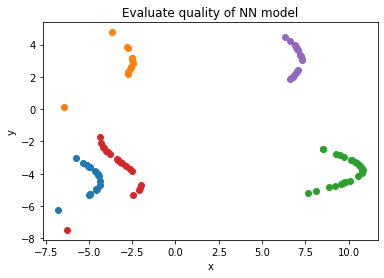

In [50]:
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1
model_input = np.concatenate([y_test.reshape(-1, 1), clusters_one_hot_test], axis=-1)

x_pred = model.predict(model_input)
plot_dataset(x_pred, y_test, cluster_assignment_test, title="Evaluate quality of NN model")

### C. Get p(y|x)

In [51]:
# specify number of points N_y, N_x for which to evaluate probability 
N_y = 4000
N_x = 4000

x_range = [x_test.min() -3, x_test.max() +3]
y_range = [y_test.min() - 3, y_test.max() +3]

In [54]:
x_sample = [6]
arguments = [x_sample, model, num_components, y_range, N_y, y_shifts]
p_y_given_x = get_probability(arguments, dataset_type="sin_or_lin_dataset")

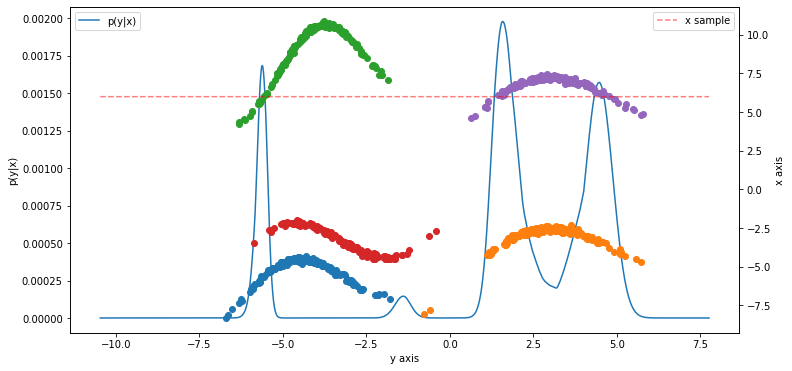

In [55]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get a heatmap

In [56]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
arguments = [x_queries, model, num_components, y_range, N_y, y_shifts]
heat_map = get_probability(arguments, dataset_type="sin_or_lin_dataset")

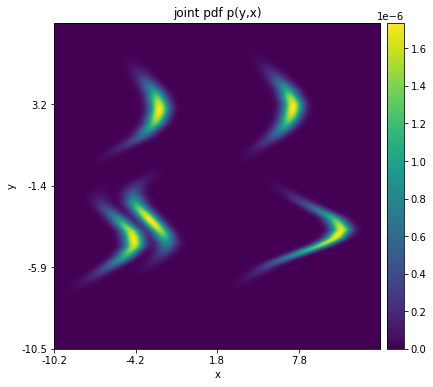

In [57]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)

# Our Localisation specific custom dataset

\begin{align}
p(i,c,t,\epsilon) & = p(i|c,\epsilon)p(c|t)p(\epsilon; \sigma)p(t) \\
p(t|i) & = \frac{\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}{\sum^T\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}
\end{align}

$p(t)=Uniform(-100,100)$ - prior, fully defined

$p(\epsilon; \sigma) = N(0,\epsilon) = N(0, 0.05)$ - prior, fully defined

$p(c|t)$

$p(i|c, \epsilon) = N(i; \mu(c), \sigma) = N(i; \mu(c), 0.05)$ - gaussian distirbution. Model parameters are $\mu(.)$ for each cluster *c*.

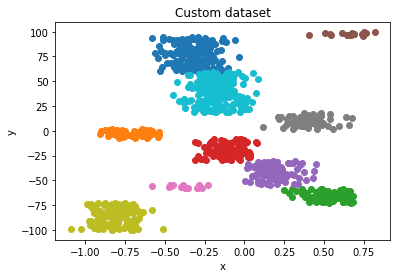

In [58]:
num_components = 10

# get dataset
data = get_dataset__simplified_localisation_problem(N=1000, C=100, num_clusters=num_components, one_to_many=True)
x, y, cluster_assignment, epsilon = data['train']
plot_dataset(x, y, cluster_assignment, title="Custom dataset")

### get a NN model to approximate p(x|c ;epsilon)

In [59]:
model = simple_model(input_shape=num_components)

In [60]:
# one-hot-encode cluster_assignment dataset
clusters_one_hot = np.zeros((cluster_assignment.size, cluster_assignment.max()+1))
clusters_one_hot[np.arange(cluster_assignment.size), cluster_assignment] = 1

In [61]:
epochs = 50

model.fit(clusters_one_hot, x, epochs=epochs)

Epoch 1/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 7/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 8/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 9/50
29/29 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 10/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 11/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 12/50
29/29 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 13/50
29/29 [==============================

### Validate NN model

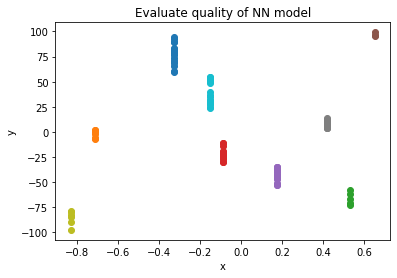

In [62]:
# visualise performance of the model. Do means for test set lie in the right clusters?
x_test, y_test, cluster_assignment_test, y_shifts = data['test']

# one-hot-encode cluster_assignment dataset
clusters_one_hot_test = np.zeros((cluster_assignment_test.size, cluster_assignment_test.max()+1))
clusters_one_hot_test[np.arange(cluster_assignment_test.size), cluster_assignment_test] = 1

x_pred = model.predict(clusters_one_hot_test)
plot_dataset(x_pred, y_test, cluster_assignment_test, title="Evaluate quality of NN model")

### Specify some parameters for computation of conditional probability p(y|x)

In [72]:
# specify number of points N_y, N_x for which to evaluate probability 
N_y = 4000
N_x = 4000

x_range = [x_test.min() - 1, x_test.max() +1]
y_range = [y_test.min() - 1, y_test.max() +1]

In [73]:
# we need to specify begining and end of each cluster to define the prior p(c_i) = Uniform(c_mins[i], c_maxs[i])
c_mins = []
c_maxs = []
for i in range(num_components):
    y_max = y[cluster_assignment == i].max()
    y_min = y[cluster_assignment == i].min()
    c_mins.append(y_min)
    c_maxs.append(y_max)

### Get and plot posterior p(y|x)

In [74]:
x_sample = [-0.2]
arguments = [x_sample, model, num_components, y_range, N_y, c_mins, c_maxs]
p_y_given_x = get_probability(arguments, dataset_type="custom_dataset")

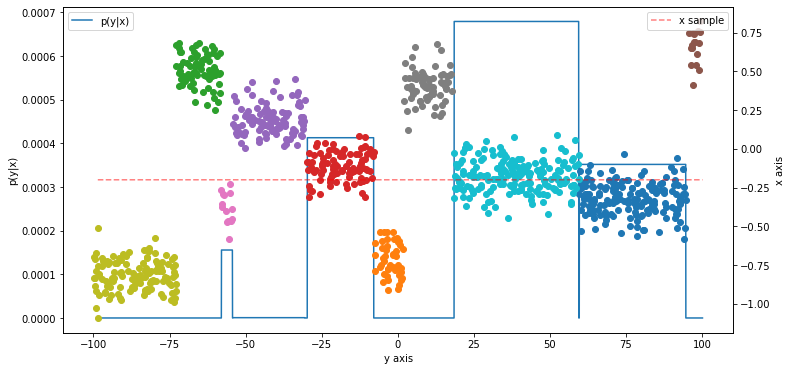

In [75]:
plot_probability(p_y_given_x, y_range, N_y, y, x, x_sample, cluster_assignment)

### Get and plot joint probability p(x,y)

In [76]:
x_queries = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N_x)
arguments = [x_queries, model, num_components, y_range, N_y, c_mins, c_maxs]
heat_map = get_probability(arguments, dataset_type="custom_dataset")

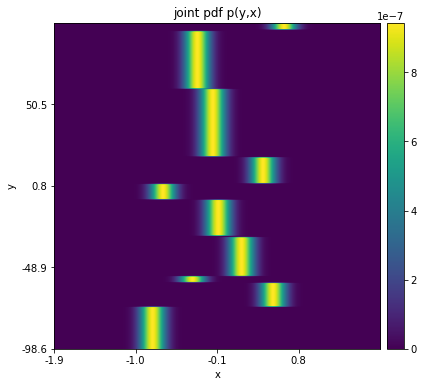

In [77]:
plot_heat_map(heat_map, x_range, y_range, N_x, N_y, tick_freq=1000)